- original paper of BEADS https://linkinghub.elsevier.com/retrieve/pii/S0169743914002032
- preprint http://www.laurent-duval.eu/Articles/Ning_X_2014_j-chemometr-intell-lab-syst_chromatogram_bedusbeads-preprint.pdf
- MATLAB toolbox http://eeweb.poly.edu/iselesni/pubs/BEADS_toolbox.zip
- pybeads repository https://github.com/skotaro/pybeads
- 日本語の解説 

# Packages an function

In [ ]:
# if you haven't, you can install the package here 
!pip install pybeads

In [2]:
import pybeads as be
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'w'

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Real chromatograms + artificial noise

## Without additional background
- The provided chromatograms have a 'well-behaved' background feature that the both ends smoothly approach to zero.
- よくみると実は両端で0に漸近しているとてもお行儀の良いBGが設定されている

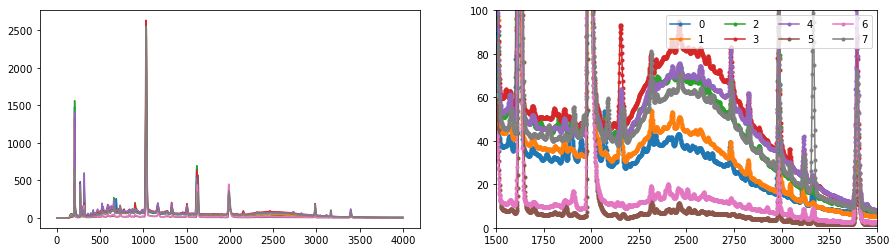

In [26]:
# Eight chromatograms with different background levels look like this
data = np.genfromtxt('chromatograms_and_noise.csv', skip_header=4, delimiter=',')
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
for i in range(8):
    axes[0].plot(data[:, i], label=i)
    axes[1].plot(data[:, i], '.-', label=i)
axes[1].set_ylim(0, 100)
axes[1].set_xlim(1500, 3500)
axes[1].legend(ncol=4)


(4000,)


(-10.0, 200.0)

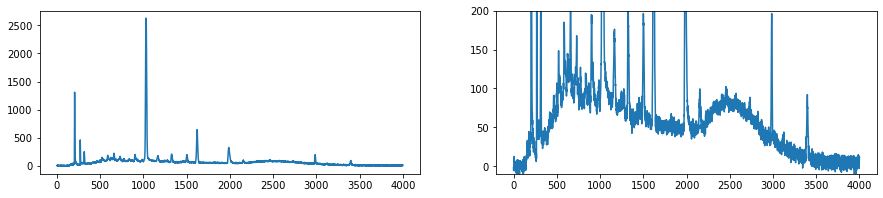

In [28]:
# We are going to use forth data + noise
y = data[:, 3] + data[:, 8]
print(y.shape)
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
axes[0].plot(y)
axes[1].plot(y)
axes[1].set_ylim(-10, 200)

In [33]:
# It takes 450 ms for 4000 data points.
fc = 0.006
d = 1
r = 6
amp = 0.8
lam0 = 0.5 * amp
lam1 = 5 * amp
lam2 = 4 * amp
Nit = 15
pen = 'L1_v2'

%timeit signal_est, bg_est, cost = be.beads(y, d, fc, r, Nit, lam0, lam1, lam2, pen, conv=None)

# Repeat this line because timeit command does not save the ouputs.
signal_est, bg_est, cost = be.beads(y, d, fc, r, Nit, lam0, lam1, lam2, pen, conv=None)


450 ms ± 9.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


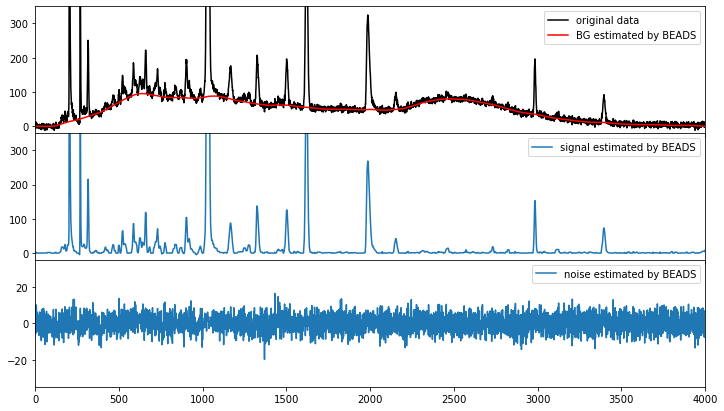

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
fig.subplots_adjust(hspace=0)
fig.patch.set_color('white')
axes[0].plot(y, c='k', label='original data')
axes[0].plot(bg_est, c='r', label='BG estimated by BEADS')
axes[0].legend()
axes[0].set_ylim(-20, 350)
axes[0].set_xlim(0, 4000)

axes[1].plot(signal_est, label='signal estimated by BEADS')
axes[1].legend()
axes[1].set_ylim(-20, 350)
axes[2].plot(y-signal_est-bg_est, label='noise estimated by BEADS')
axes[2].set_ylim(-35, 35)
axes[2].legend()

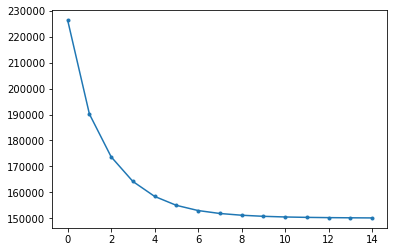

In [35]:
plt.plot(cost, '.-')

## Adding constant backgroud
- This simple additional BG gets the job undone because now the both ends is off the zero line
- こんな単純なBGを出すだけでだめになる。両端が0になっていないため。

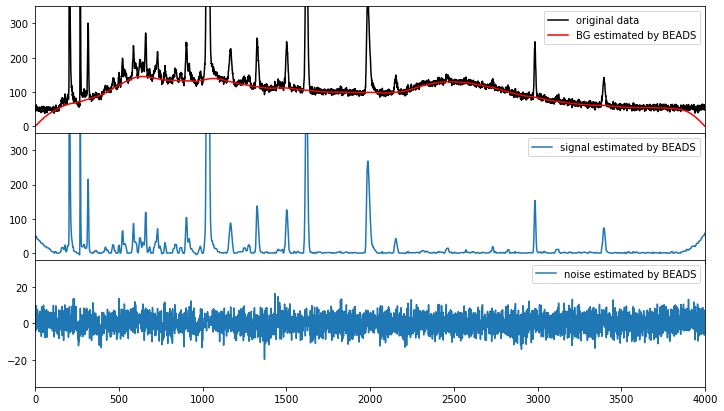

In [68]:
bg_const = 50
signal_est, bg_est, cost = be.beads(y+bg_const, d, fc, r, Nit, lam0, lam1, lam2, pen, conv=None)
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
fig.subplots_adjust(hspace=0)
fig.patch.set_color('white')
axes[0].plot(y+bg_const, c='k', label='original data')
axes[0].plot(bg_est, c='r', label='BG estimated by BEADS')
axes[0].legend()
axes[0].set_ylim(-20, 350)
axes[0].set_xlim(0, 4000)

axes[1].plot(signal_est, label='signal estimated by BEADS')
axes[1].legend()
axes[1].set_ylim(-20, 350)
axes[2].plot(y+bg_const-signal_est-bg_est, label='noise estimated by BEADS')
axes[2].set_ylim(-35, 35)
axes[2].legend()

## Adding nasty background
- But it works if you do a trick.
- こんなになってもある工夫をするとうまくいく。

(0.0, 350.0)

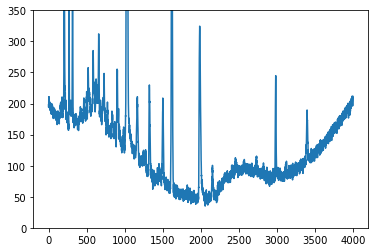

In [37]:
# Oh, it's awful...
bg = 5e-5*(np.linspace(0, 3999, num=4000)-2000)**2
y_difficult = y + bg
plt.plot(y_difficult)
plt.ylim(0, 350)

## Extending the data with sigmoid function
- To make the both ends smoothly approaching to zero, we extend the data with sigmoid function.
- 両端を滑らかにゼロに近づけるため、シグモイド関数で延長してみる

(0.0, 350.0)

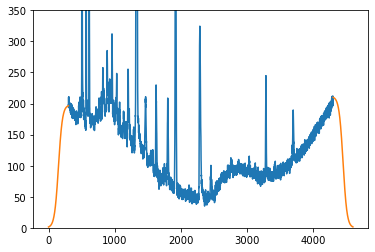

In [38]:
xscale_l, xscale_r = 30, 30
dx = 1
y_difficult_l = y_difficult[0]*sigmoid(1/xscale_l*np.arange(-5*xscale_l, 5*xscale_l, dx))
y_difficult_r = y_difficult[-1]*sigmoid(-1/xscale_r*np.arange(-5*xscale_r, 5*xscale_r, dx))
y_difficult_ext = np.hstack([y_difficult_l, y_difficult, y_difficult_r])
len_l, len_o, len_r = len(y_difficult_l), len(y_difficult), len(y_difficult_r)
plt.plot(range(len_l, len_l+len_o), y_difficult)
plt.plot(y_difficult_l, 'C1')
plt.plot(range(len_l+len_o, len_l+len_o+len_r), y_difficult_r, 'C1')
plt.ylim(0, 350)

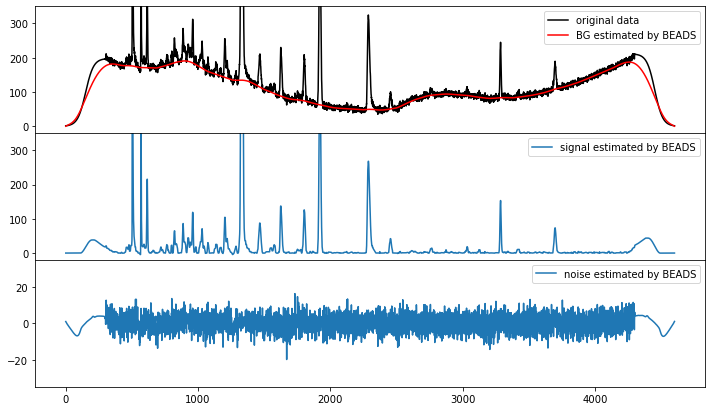

In [39]:
# Very close. 

signal_est, bg_est, cost = be.beads(y_difficult_ext, d, fc, r, Nit, lam0, lam1, lam2, pen, conv=None)
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
fig.subplots_adjust(hspace=0)
fig.patch.set_color('white')
axes[0].plot(y_difficult_ext, c='k', label='original data')
axes[0].plot(bg_est, c='r', label='BG estimated by BEADS')
axes[0].legend()
axes[0].set_ylim(-20, 350)

axes[1].plot(signal_est, label='signal estimated by BEADS')
axes[1].legend()
axes[1].set_ylim(-20, 350)
axes[2].plot(y_difficult_ext-signal_est-bg_est, label='noise estimated by BEADS')
axes[2].set_ylim(-35, 35)
axes[2].legend()

(0.0, 350.0)

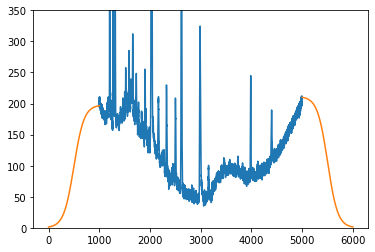

In [41]:
# We need the extension more stretched.

xscale_l, xscale_r = 100, 100
dx = 1
y_difficult_l = y_difficult[0]*sigmoid(1/xscale_l*np.arange(-5*xscale_l, 5*xscale_l, dx))
y_difficult_r = y_difficult[-1]*sigmoid(-1/xscale_r*np.arange(-5*xscale_r, 5*xscale_r, dx))
y_difficult_ext = np.hstack([y_difficult_l, y_difficult, y_difficult_r])
len_l, len_o, len_r = len(y_difficult_l), len(y_difficult), len(y_difficult_r)
plt.plot(range(len_l, len_l+len_o), y_difficult)
plt.plot(y_difficult_l, 'C1')
plt.plot(range(len_l+len_o, len_l+len_o+len_r), y_difficult_r, 'C1')
plt.ylim(0, 350)

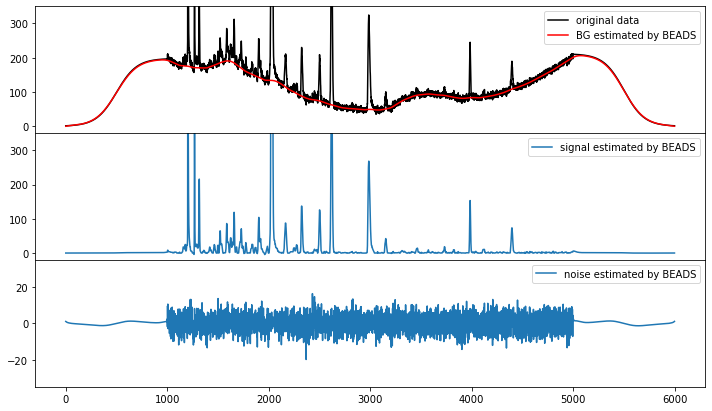

In [42]:
signal_est, bg_est, cost = be.beads(y_difficult_ext, d, fc, r, Nit, lam0, lam1, lam2, pen, conv=None)
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
fig.subplots_adjust(hspace=0)
fig.patch.set_color('white')
axes[0].plot(y_difficult_ext, c='k', label='original data')
axes[0].plot(bg_est, c='r', label='BG estimated by BEADS')
axes[0].legend()
axes[0].set_ylim(-20, 350)

axes[1].plot(signal_est, label='signal estimated by BEADS')
axes[1].legend()
axes[1].set_ylim(-20, 350)
axes[2].plot(y_difficult_ext-signal_est-bg_est, label='noise estimated by BEADS')
axes[2].set_ylim(-35, 35)
axes[2].legend()